# Load Data

In [ ]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import notebook
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
(x_train, y_train),(x_val, y_val) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
data = np.vstack([x_train, x_val])
label = np.vstack([y_train.reshape(-1,1), y_val.reshape(-1, 1)]) 

In [ ]:
data = (data.astype('float32') - 127.5) / 127.5

In [ ]:
data = data.reshape(-1,784)

In [ ]:
adam = Adam(learning_rate= 0.0002, beta_1= 0.5)

# Build model

In [ ]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model, Sequential

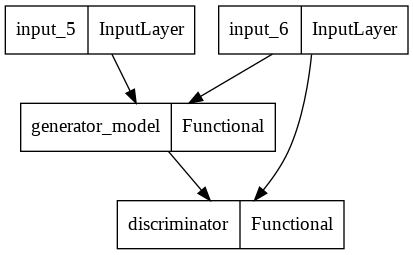

In [ ]:
def generator(dim_noise = 100, n_classes = 10):
    input_label = Input(shape = (1,))
    y = Embedding(n_classes, 50, input_length=1)(input_label)
    y = Dense(7 * 7, use_bias = False)(y)
    y = Reshape((7,7,1))(y)
    input_noise = Input(shape = (dim_noise,))
    x = Dense(7 * 7 * 128, use_bias = False)(input_noise)
    x = Reshape((7,7,128))(x)
    x = Concatenate()([x, y])
    x = Conv2DTranspose(128, kernel_size = (3,3), strides = 2, padding = 'same')(x) # 14
   
    x = LeakyReLU(0.2)(x)
    x = Conv2DTranspose(128, kernel_size = (3,3), strides = 2, padding = 'same')(x) 
    
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size= (3,3), strides= 1, padding= 'same', activation= 'tanh')(x)
    x = Flatten()(x)
    return Model([input_noise, input_label], x, name = 'generator_model')

def discriminator(n_classes = 10):
    input_img = Input(shape = (28 * 28))
    x = Reshape((28,28,1))(input_img)
    input_label = Input(shape = (1,))
    y = Embedding(n_classes, 50)(input_label)
    y = Dense(28 * 28, use_bias = False)(y)
    y = Reshape((28,28,1))(y)
    x = Concatenate()([x,y])
    x = Conv2D(128, kernel_size = (5,5), strides = 2, padding = 'same')(x) # 14
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size = (3,3), strides = 2, padding = 'same')(x) # 7
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation = 'sigmoid')(x)
    return Model([input_img, input_label], x, name = 'discriminator')
g = generator()
d = discriminator()
d.tranable = False
g.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])
d.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])
z = Input(shape = (100,))
label_shape = Input(shape = (1,))
img = g([z,label_shape])
prediction = d([img,label_shape])
gan_model = Model([z,label_shape], prediction)
gan_model.compile(loss= 'mse', optimizer = adam, metrics = ['acc'])
tf.keras.utils.plot_model(gan_model,)

In [ ]:
def show_example(gan_model):
    noise = np.random.normal(size = (10,100))
    label = np.arange(0,10)
    image_generate = gan_model.layers[2]([noise,label]).numpy().reshape(-1,28,28)
    plt.figure(figsize= (12,2))
    for i in range(10):
        plt.subplot(1,10,i + 1)
        plt.imshow(image_generate[i], interpolation='nearest', cmap='gray_r' )
        plt.axis('off')
    plt.show()

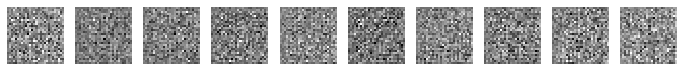

In [ ]:
# test code
show_example(gan_model)

# Train

In [ ]:
def train(gan_model, image, label, batch_size = 256, epochs = 100, verbose = 1, num_classes = 10):
    interation = int(len(image) / batch_size)
    indexes = np.arange(len(image))
    
    for i in range(1, epochs + 1):
        if i % verbose == 0:
            print(f'Epochs {i}: ', end= '')
        indexes = np.arange(len(image))
        indexes = shuffle(indexes)
        fake_acc, real_acc = [], []
        loss_D, loss_G = [], []
        for j in notebook.tqdm(range(interation)):
            index = indexes[j * batch_size : (j + 1) * batch_size]
            real_img = np.array([image[k] for k in index])
            labels = np.array([label[k] for k in index])
            # sinh ảnh từ noise
            noise = np.random.normal(size = (batch_size, 100))
            fake_img = gan_model.layers[2]([noise, labels])
        
            # nhiễu label
            y = np.ones(batch_size * 2)
            y[:batch_size] = 0.9 # real_img
            y[batch_size:] = 0.1 # fake_img
            # train discriminator
            gan_model.layers[3].trainable = True
            loss_real = gan_model.layers[3].train_on_batch([real_img, labels],y[:batch_size])
            loss_fake = gan_model.layers[3].train_on_batch([fake_img, labels],y[batch_size:])
            
            loss_d = 0.5 * np.add(loss_real, loss_fake)
            
            loss_D.append(loss_d)
            
            fake_acc.append(loss_fake[1])
            real_acc.append(loss_real[1])
            # train generator
            fake_img = np.random.normal(size = (batch_size, 100))
            labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            y_fake = np.ones(batch_size)
            gan_model.layers[3].trainable = False
            loss_g = gan_model.train_on_batch([fake_img, labels],y_fake)
            loss_G.append(loss_g)

        if i % verbose == 0:
            show_example(gan_model)
            print('d_loss: %f   g_loss: %f' % (np.array(loss_D).mean(), np.array(loss_G).mean()))

Epochs 1: 

  0%|          | 0/273 [00:00<?, ?it/s]

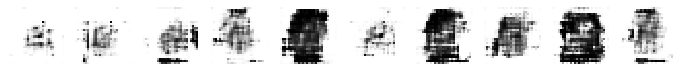

d_loss: 0.086553   g_loss: 0.569016
Epochs 2: 

  0%|          | 0/273 [00:00<?, ?it/s]

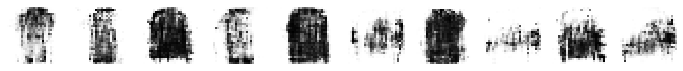

d_loss: 0.092692   g_loss: 0.559917
Epochs 3: 

  0%|          | 0/273 [00:00<?, ?it/s]

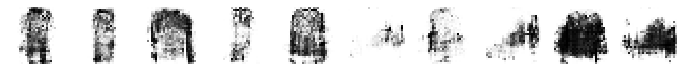

d_loss: 0.093334   g_loss: 0.558962
Epochs 4: 

  0%|          | 0/273 [00:00<?, ?it/s]

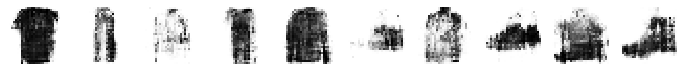

d_loss: 0.092093   g_loss: 0.559627
Epochs 5: 

  0%|          | 0/273 [00:00<?, ?it/s]

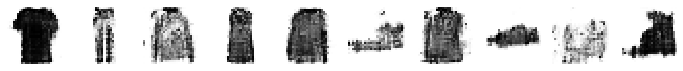

d_loss: 0.092213   g_loss: 0.559255
Epochs 6: 

  0%|          | 0/273 [00:00<?, ?it/s]

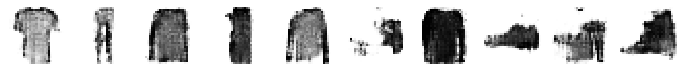

d_loss: 0.092502   g_loss: 0.558876
Epochs 7: 

  0%|          | 0/273 [00:00<?, ?it/s]

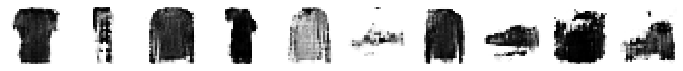

d_loss: 0.092724   g_loss: 0.558675
Epochs 8: 

  0%|          | 0/273 [00:00<?, ?it/s]

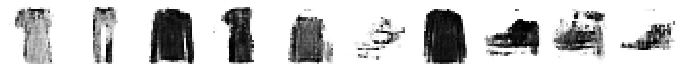

d_loss: 0.092777   g_loss: 0.558495
Epochs 9: 

  0%|          | 0/273 [00:00<?, ?it/s]

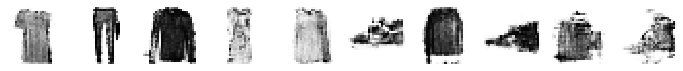

d_loss: 0.092789   g_loss: 0.558434
Epochs 10: 

  0%|          | 0/273 [00:00<?, ?it/s]

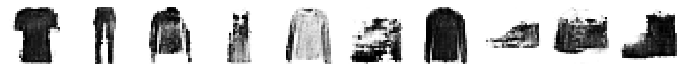

d_loss: 0.092884   g_loss: 0.558295
Epochs 11: 

  0%|          | 0/273 [00:00<?, ?it/s]

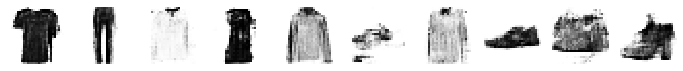

d_loss: 0.092851   g_loss: 0.558304
Epochs 12: 

  0%|          | 0/273 [00:00<?, ?it/s]

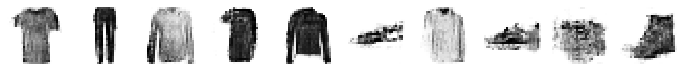

d_loss: 0.092722   g_loss: 0.558331
Epochs 13: 

  0%|          | 0/273 [00:00<?, ?it/s]

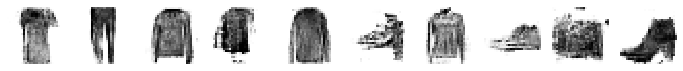

d_loss: 0.092687   g_loss: 0.558349
Epochs 14: 

  0%|          | 0/273 [00:00<?, ?it/s]

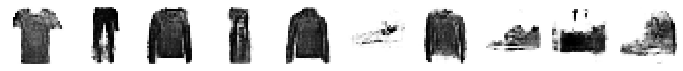

d_loss: 0.092654   g_loss: 0.558379
Epochs 15: 

  0%|          | 0/273 [00:00<?, ?it/s]

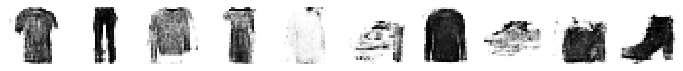

d_loss: 0.092549   g_loss: 0.558422
Epochs 16: 

  0%|          | 0/273 [00:00<?, ?it/s]

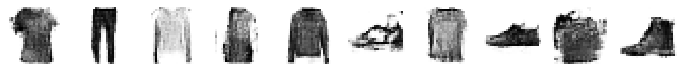

d_loss: 0.092469   g_loss: 0.558436
Epochs 17: 

  0%|          | 0/273 [00:00<?, ?it/s]

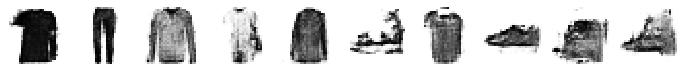

d_loss: 0.092467   g_loss: 0.558498
Epochs 18: 

  0%|          | 0/273 [00:00<?, ?it/s]

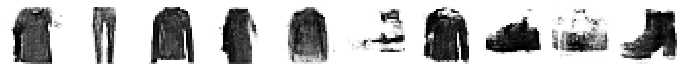

d_loss: 0.092254   g_loss: 0.558646
Epochs 19: 

  0%|          | 0/273 [00:00<?, ?it/s]

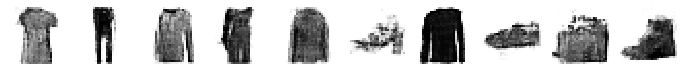

d_loss: 0.092253   g_loss: 0.558618
Epochs 20: 

  0%|          | 0/273 [00:00<?, ?it/s]

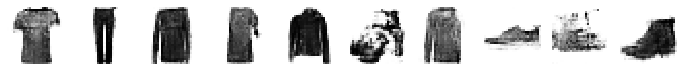

d_loss: 0.092259   g_loss: 0.558642
Epochs 21: 

  0%|          | 0/273 [00:00<?, ?it/s]

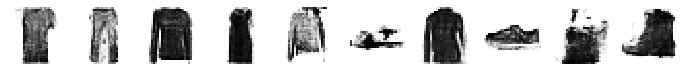

d_loss: 0.092156   g_loss: 0.558713
Epochs 22: 

  0%|          | 0/273 [00:00<?, ?it/s]

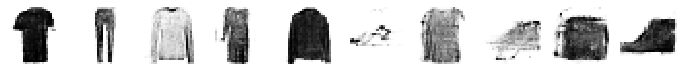

d_loss: 0.092022   g_loss: 0.558882
Epochs 23: 

  0%|          | 0/273 [00:00<?, ?it/s]

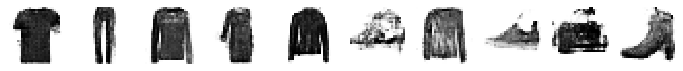

d_loss: 0.091989   g_loss: 0.558791
Epochs 24: 

  0%|          | 0/273 [00:00<?, ?it/s]

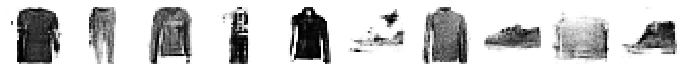

d_loss: 0.091924   g_loss: 0.559016
Epochs 25: 

  0%|          | 0/273 [00:00<?, ?it/s]

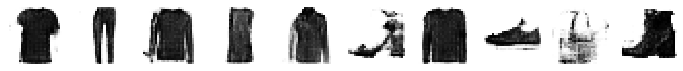

d_loss: 0.091878   g_loss: 0.558920
Epochs 26: 

  0%|          | 0/273 [00:00<?, ?it/s]

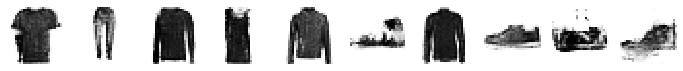

d_loss: 0.091843   g_loss: 0.559064
Epochs 27: 

  0%|          | 0/273 [00:00<?, ?it/s]

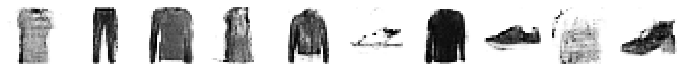

d_loss: 0.091744   g_loss: 0.559094
Epochs 28: 

  0%|          | 0/273 [00:00<?, ?it/s]

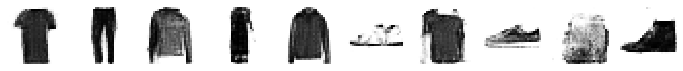

d_loss: 0.091728   g_loss: 0.559141
Epochs 29: 

  0%|          | 0/273 [00:00<?, ?it/s]

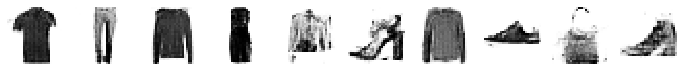

d_loss: 0.091700   g_loss: 0.559191
Epochs 30: 

  0%|          | 0/273 [00:00<?, ?it/s]

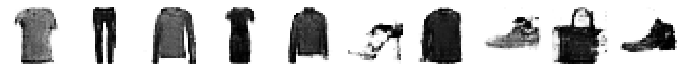

d_loss: 0.091630   g_loss: 0.559278
Epochs 31: 

  0%|          | 0/273 [00:00<?, ?it/s]

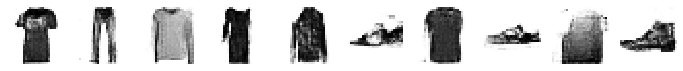

d_loss: 0.091599   g_loss: 0.559317
Epochs 32: 

  0%|          | 0/273 [00:00<?, ?it/s]

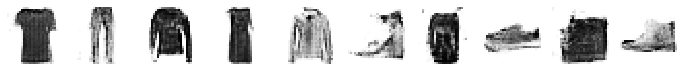

d_loss: 0.091558   g_loss: 0.559374
Epochs 33: 

  0%|          | 0/273 [00:00<?, ?it/s]

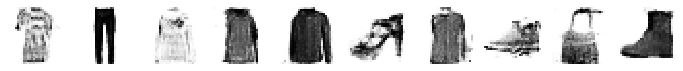

d_loss: 0.091552   g_loss: 0.559492
Epochs 34: 

  0%|          | 0/273 [00:00<?, ?it/s]

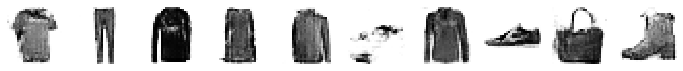

d_loss: 0.091520   g_loss: 0.559494
Epochs 35: 

  0%|          | 0/273 [00:00<?, ?it/s]

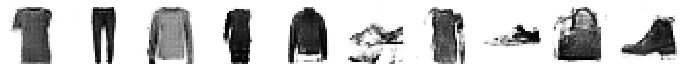

d_loss: 0.091423   g_loss: 0.559523
Epochs 36: 

  0%|          | 0/273 [00:00<?, ?it/s]

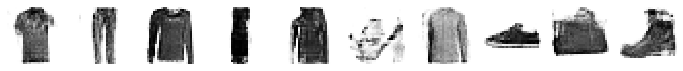

d_loss: 0.091399   g_loss: 0.559606
Epochs 37: 

  0%|          | 0/273 [00:00<?, ?it/s]

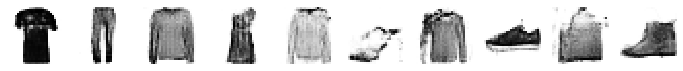

d_loss: 0.091326   g_loss: 0.559688
Epochs 38: 

  0%|          | 0/273 [00:00<?, ?it/s]

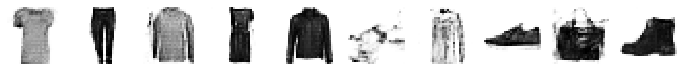

d_loss: 0.091266   g_loss: 0.559760
Epochs 39: 

  0%|          | 0/273 [00:00<?, ?it/s]

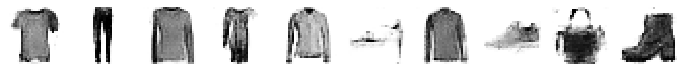

d_loss: 0.091223   g_loss: 0.559843
Epochs 40: 

  0%|          | 0/273 [00:00<?, ?it/s]

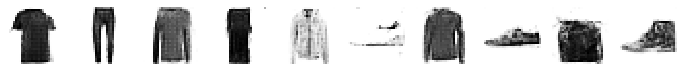

d_loss: 0.091126   g_loss: 0.559908
Epochs 41: 

  0%|          | 0/273 [00:00<?, ?it/s]

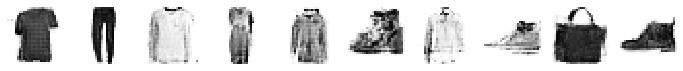

d_loss: 0.091052   g_loss: 0.559906
Epochs 42: 

  0%|          | 0/273 [00:00<?, ?it/s]

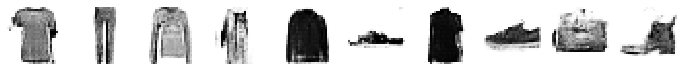

d_loss: 0.090981   g_loss: 0.560051
Epochs 43: 

  0%|          | 0/273 [00:00<?, ?it/s]

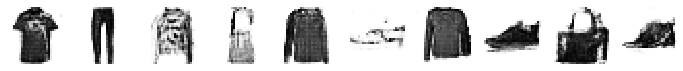

d_loss: 0.090926   g_loss: 0.560104
Epochs 44: 

  0%|          | 0/273 [00:00<?, ?it/s]

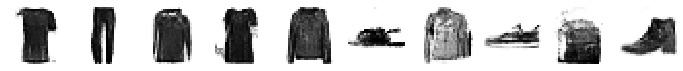

d_loss: 0.090909   g_loss: 0.560267
Epochs 45: 

  0%|          | 0/273 [00:00<?, ?it/s]

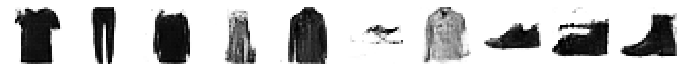

d_loss: 0.090798   g_loss: 0.560296
Epochs 46: 

  0%|          | 0/273 [00:00<?, ?it/s]

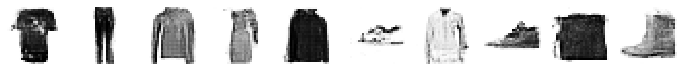

d_loss: 0.090735   g_loss: 0.560406
Epochs 47: 

  0%|          | 0/273 [00:00<?, ?it/s]

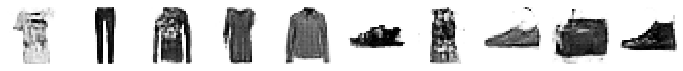

d_loss: 0.090627   g_loss: 0.560501
Epochs 48: 

  0%|          | 0/273 [00:00<?, ?it/s]

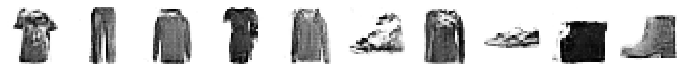

d_loss: 0.090543   g_loss: 0.560583
Epochs 49: 

  0%|          | 0/273 [00:00<?, ?it/s]

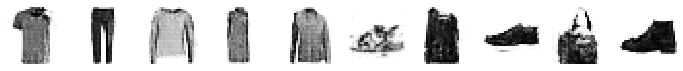

d_loss: 0.090467   g_loss: 0.560728
Epochs 50: 

  0%|          | 0/273 [00:00<?, ?it/s]

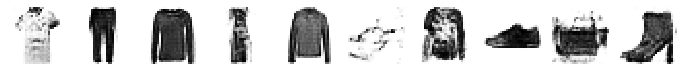

d_loss: 0.090419   g_loss: 0.560702
Epochs 51: 

  0%|          | 0/273 [00:00<?, ?it/s]

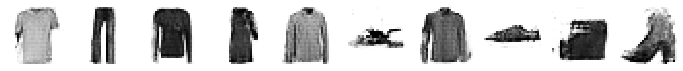

d_loss: 0.090444   g_loss: 0.560771
Epochs 52: 

  0%|          | 0/273 [00:00<?, ?it/s]

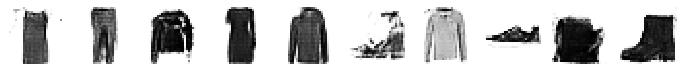

d_loss: 0.090348   g_loss: 0.560909
Epochs 53: 

  0%|          | 0/273 [00:00<?, ?it/s]

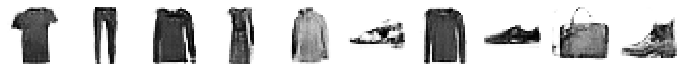

d_loss: 0.090235   g_loss: 0.561006
Epochs 54: 

  0%|          | 0/273 [00:00<?, ?it/s]

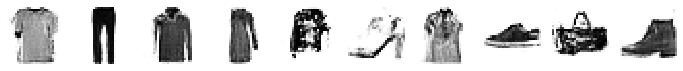

d_loss: 0.090183   g_loss: 0.561067
Epochs 55: 

  0%|          | 0/273 [00:00<?, ?it/s]

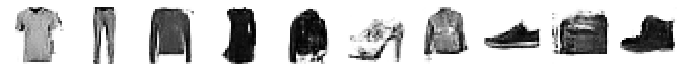

d_loss: 0.090190   g_loss: 0.561013
Epochs 56: 

  0%|          | 0/273 [00:00<?, ?it/s]

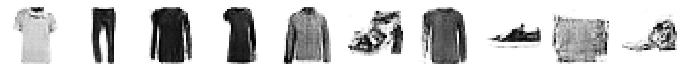

d_loss: 0.090187   g_loss: 0.561133
Epochs 57: 

  0%|          | 0/273 [00:00<?, ?it/s]

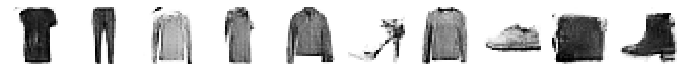

d_loss: 0.090180   g_loss: 0.561067
Epochs 58: 

  0%|          | 0/273 [00:00<?, ?it/s]

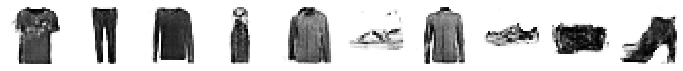

d_loss: 0.090028   g_loss: 0.561243
Epochs 59: 

  0%|          | 0/273 [00:00<?, ?it/s]

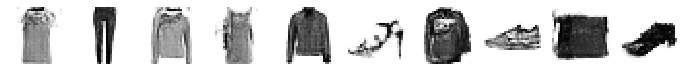

d_loss: 0.089970   g_loss: 0.561315
Epochs 60: 

  0%|          | 0/273 [00:00<?, ?it/s]

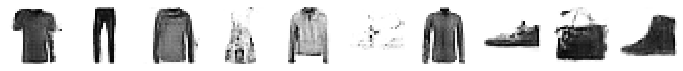

d_loss: 0.089922   g_loss: 0.561419
Epochs 61: 

  0%|          | 0/273 [00:00<?, ?it/s]

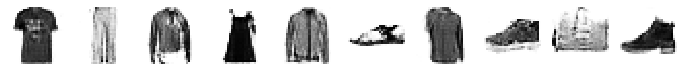

d_loss: 0.089739   g_loss: 0.561539
Epochs 62: 

  0%|          | 0/273 [00:00<?, ?it/s]

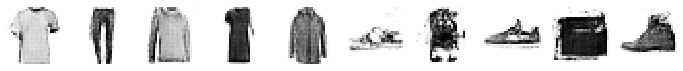

d_loss: 0.089760   g_loss: 0.561581
Epochs 63: 

  0%|          | 0/273 [00:00<?, ?it/s]

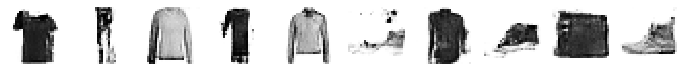

d_loss: 0.089711   g_loss: 0.561712
Epochs 64: 

  0%|          | 0/273 [00:00<?, ?it/s]

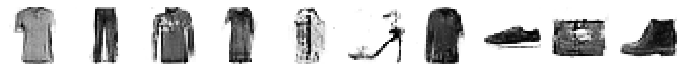

d_loss: 0.089601   g_loss: 0.561762
Epochs 65: 

  0%|          | 0/273 [00:00<?, ?it/s]

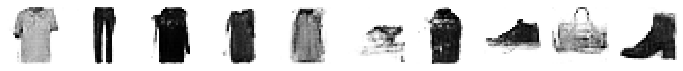

d_loss: 0.089669   g_loss: 0.561625
Epochs 66: 

  0%|          | 0/273 [00:00<?, ?it/s]

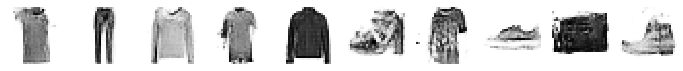

d_loss: 0.089662   g_loss: 0.561677
Epochs 67: 

  0%|          | 0/273 [00:00<?, ?it/s]

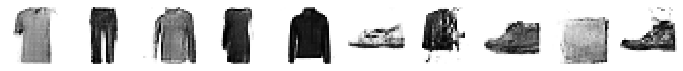

d_loss: 0.089550   g_loss: 0.561795
Epochs 68: 

  0%|          | 0/273 [00:00<?, ?it/s]

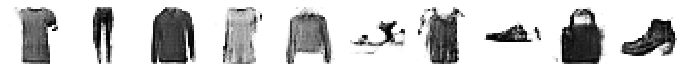

d_loss: 0.089573   g_loss: 0.561823
Epochs 69: 

  0%|          | 0/273 [00:00<?, ?it/s]

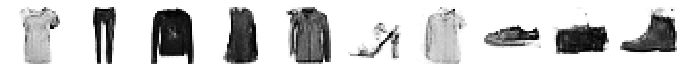

d_loss: 0.089488   g_loss: 0.561789
Epochs 70: 

  0%|          | 0/273 [00:00<?, ?it/s]

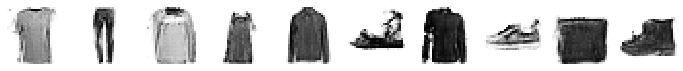

d_loss: 0.089494   g_loss: 0.561872
Epochs 71: 

  0%|          | 0/273 [00:00<?, ?it/s]

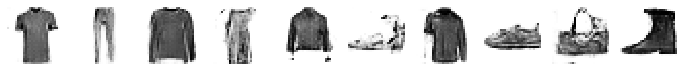

d_loss: 0.089455   g_loss: 0.561843
Epochs 72: 

  0%|          | 0/273 [00:00<?, ?it/s]

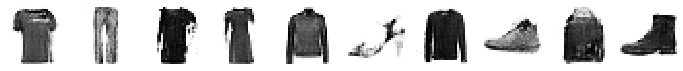

d_loss: 0.089358   g_loss: 0.562052
Epochs 73: 

  0%|          | 0/273 [00:00<?, ?it/s]

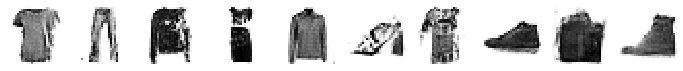

d_loss: 0.089392   g_loss: 0.562074
Epochs 74: 

  0%|          | 0/273 [00:00<?, ?it/s]

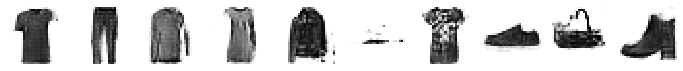

d_loss: 0.089185   g_loss: 0.562174
Epochs 75: 

  0%|          | 0/273 [00:00<?, ?it/s]

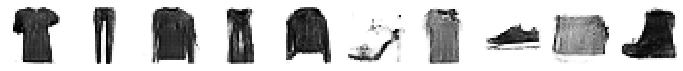

d_loss: 0.089250   g_loss: 0.562162
Epochs 76: 

  0%|          | 0/273 [00:00<?, ?it/s]

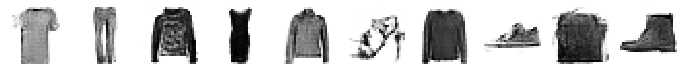

d_loss: 0.089224   g_loss: 0.562178
Epochs 77: 

  0%|          | 0/273 [00:00<?, ?it/s]

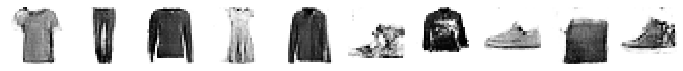

d_loss: 0.089095   g_loss: 0.562131
Epochs 78: 

  0%|          | 0/273 [00:00<?, ?it/s]

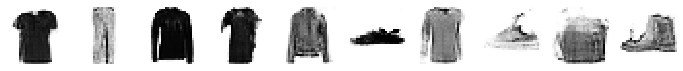

d_loss: 0.089167   g_loss: 0.562202
Epochs 79: 

  0%|          | 0/273 [00:00<?, ?it/s]

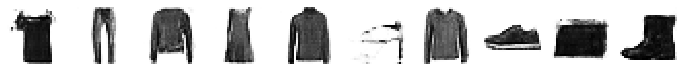

d_loss: 0.089074   g_loss: 0.562307
Epochs 80: 

  0%|          | 0/273 [00:00<?, ?it/s]

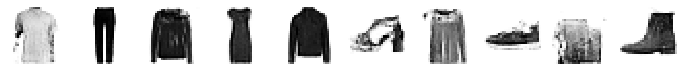

d_loss: 0.089004   g_loss: 0.562203
Epochs 81: 

  0%|          | 0/273 [00:00<?, ?it/s]

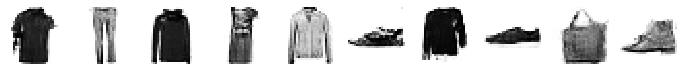

d_loss: 0.089142   g_loss: 0.562297
Epochs 82: 

  0%|          | 0/273 [00:00<?, ?it/s]

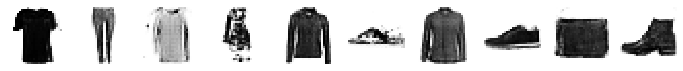

d_loss: 0.089070   g_loss: 0.562368
Epochs 83: 

  0%|          | 0/273 [00:00<?, ?it/s]

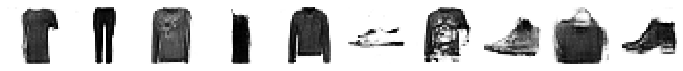

d_loss: 0.089038   g_loss: 0.562365
Epochs 84: 

  0%|          | 0/273 [00:00<?, ?it/s]

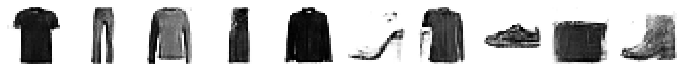

d_loss: 0.088990   g_loss: 0.562405
Epochs 85: 

  0%|          | 0/273 [00:00<?, ?it/s]

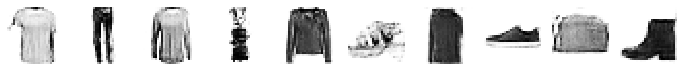

d_loss: 0.088944   g_loss: 0.562300
Epochs 86: 

  0%|          | 0/273 [00:00<?, ?it/s]

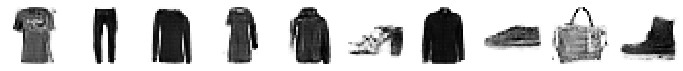

d_loss: 0.088883   g_loss: 0.562412
Epochs 87: 

  0%|          | 0/273 [00:00<?, ?it/s]

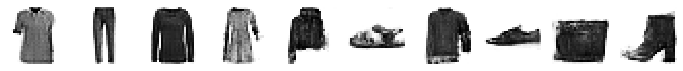

d_loss: 0.088829   g_loss: 0.562542
Epochs 88: 

  0%|          | 0/273 [00:00<?, ?it/s]

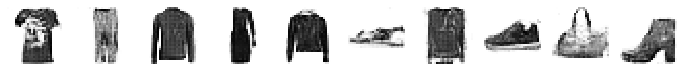

d_loss: 0.088729   g_loss: 0.562567
Epochs 89: 

  0%|          | 0/273 [00:00<?, ?it/s]

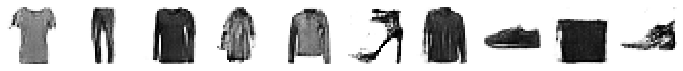

d_loss: 0.088756   g_loss: 0.562668
Epochs 90: 

  0%|          | 0/273 [00:00<?, ?it/s]

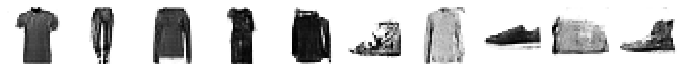

d_loss: 0.088819   g_loss: 0.562770
Epochs 91: 

  0%|          | 0/273 [00:00<?, ?it/s]

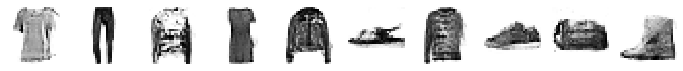

d_loss: 0.088750   g_loss: 0.562658
Epochs 92: 

  0%|          | 0/273 [00:00<?, ?it/s]

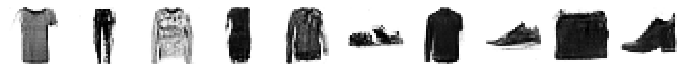

d_loss: 0.088683   g_loss: 0.562783
Epochs 93: 

  0%|          | 0/273 [00:00<?, ?it/s]

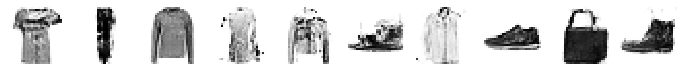

d_loss: 0.088625   g_loss: 0.562698
Epochs 94: 

  0%|          | 0/273 [00:00<?, ?it/s]

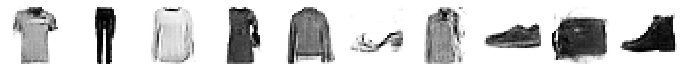

d_loss: 0.088769   g_loss: 0.562640
Epochs 95: 

  0%|          | 0/273 [00:00<?, ?it/s]

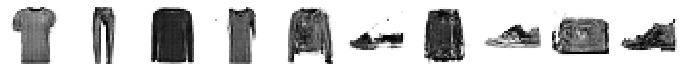

d_loss: 0.088718   g_loss: 0.562646
Epochs 96: 

  0%|          | 0/273 [00:00<?, ?it/s]

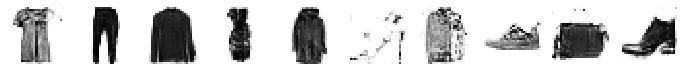

d_loss: 0.088701   g_loss: 0.562622
Epochs 97: 

  0%|          | 0/273 [00:00<?, ?it/s]

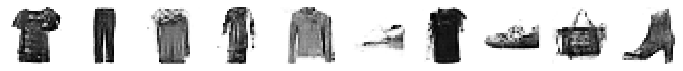

d_loss: 0.088759   g_loss: 0.562687
Epochs 98: 

  0%|          | 0/273 [00:00<?, ?it/s]

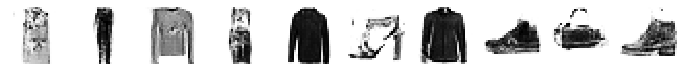

d_loss: 0.088623   g_loss: 0.562786
Epochs 99: 

  0%|          | 0/273 [00:00<?, ?it/s]

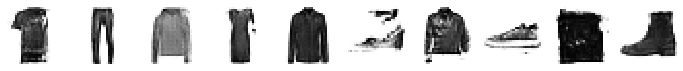

d_loss: 0.088665   g_loss: 0.562749
Epochs 100: 

  0%|          | 0/273 [00:00<?, ?it/s]

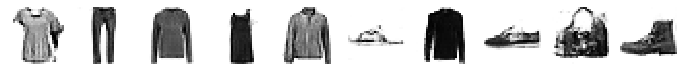

d_loss: 0.088598   g_loss: 0.562639


In [ ]:
train(gan_model, data, label)

In [ ]:
gan_model.save('cgan.h5')